In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

import d6tflow
# d6tflow uses luigi to intelligently pass parameters upstream and downstream
import luigi
from luigi.util import inherits, requires

d6tflow.set_dir("d6tflow_hate_speech/")
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s",level=logging.INFO)

Using TensorFlow backend.
Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.


Welcome to d6tflow!


# Loading Data
***

In [2]:
DATA_DIR = "data/hate_speech_tweet_data/"

In [3]:
def load_data( data_dir ):
    train_file_name = "tweet_train_set.csv"
    test_file_name = "tweet_test_set.csv"
    train_set = pd.read_csv(os.path.join(data_dir,train_file_name))
    logging.info("Train set loaded")
    test_set = pd.read_csv(os.path.join(data_dir,test_file_name))
    logging.info("Test set loaded")
    return train_set, test_set

In [4]:
x_train, x_test = load_data( DATA_DIR )

2019-11-14 21:57:19,833 : INFO : Train set loaded
2019-11-14 21:57:19,862 : INFO : Test set loaded


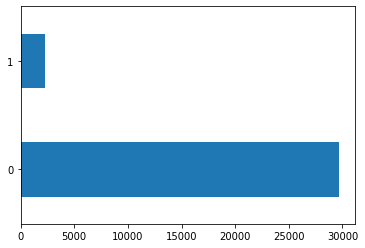

In [5]:
x_train.label.value_counts().plot(kind='barh')
plt.show()

# Preprocessing Pipeline
***

In [6]:
REMOVE_PUNCTUATION = False
LEMMATIZE = False
REMOVE_STOPWORDS = False
REMOVE_SHORT_TWEETS = 4

In [7]:
not_alpha_nor_hashtag = "[^a-zA-Z#]"
punctuation = "[{}]".format(string.punctuation)
stop_words = stopwords.words("english")

Tokenize Tweets

In [8]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

In [9]:
tokenized_training_data = x_train.tweet.apply(tokenizer.tokenize)

Remove Punctuation

In [10]:
def remove_punctuation(tokenized_tweet):
    tweet_less_punctuation = tokenized_tweet
    for word in tokenized_tweet:
        if word in punctuation:
            tweet_less_punctuation.remove(word)
    return tweet_less_punctuation

if REMOVE_PUNCTUATION:
    tokenized_training_data = tokenized_training_data.apply(remove_punctuation)

Remove stopwords

In [11]:
def remove_stopwords(tokenized_tweet):
    tweet_less_stopwords = tokenized_tweet
    for word in tokenized_tweet:
        if word in stop_words:
            tweet_less_stopwords.remove(word)
    return tweet_less_stopwords

if REMOVE_STOPWORDS:
    tokenized_training_data = tokenized_training_data.apply(remove_stopwords)

Lemmatize

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(tokenized_tweet):
    for i, word in enumerate(tokenized_tweet):
        tokenized_tweet[i] = lemmatizer.lemmatize(word)
    return tokenized_tweet
        
if LEMMATIZE:
    tokenized_training_data.apply(lemmatize_tweet)

Remove Tweets Shorter Than Length `REMOVE_SHORT_TWEETS`

In [13]:
tokenized_training_data = tokenized_training_data[tokenized_training_data.str.len() >= REMOVE_SHORT_TWEETS]

# Exploratory Data Analysis
***

# Perform Vectorization
***

In [14]:
embedding_dimension = 1000
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=embedding_dimension, stop_words="english")
train_vectors = vectorizer.fit_transform(x_train.tweet)

# Build a Baseline Model
***

In [15]:
train_data, val_data, y_train, y_val = train_test_split(train_vectors, \
        x_train.label, test_size=0.10, random_state=42)

In [16]:
baseline_classifier = LogisticRegression()

In [17]:
baseline_classifier.fit(train_data, y_train)

/home/joseph/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
predictions = baseline_classifier.predict(val_data)

In [19]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2984
           1       0.77      0.34      0.47       213

    accuracy                           0.95      3197
   macro avg       0.86      0.67      0.72      3197
weighted avg       0.94      0.95      0.94      3197



# Build a Deep Model
***

In [20]:
EMBEDDING_DIM = embedding_dimension
vocabulary = vectorizer.vocabulary_
vocab_size = len(vocabulary)
max_length = x_train.tweet.str.len().max()

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


2019-11-14 21:57:22,985 : WARNING : From /home/joseph/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-11-14 21:57:23,056 : WARNING : From /home/joseph/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 274, 1000)         1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                99168     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,099,201
Trainable params: 1,099,201
Non-trainable params: 0
_________________________________________________________________
None
